In [2]:
import sys
import numpy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans
import random
import torch


In [3]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    

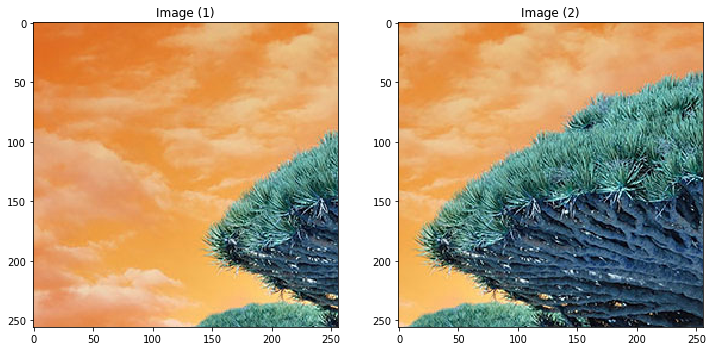

[[ 8.61489036e-01 -3.80343826e-03  5.04211910e+00]
 [-3.32485571e-02  9.30641288e-01  1.08383336e+00]
 [-5.72553732e-04 -2.00180961e-04  1.00000000e+00]]


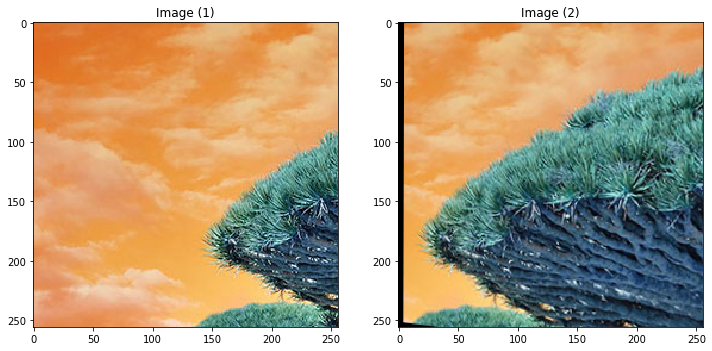

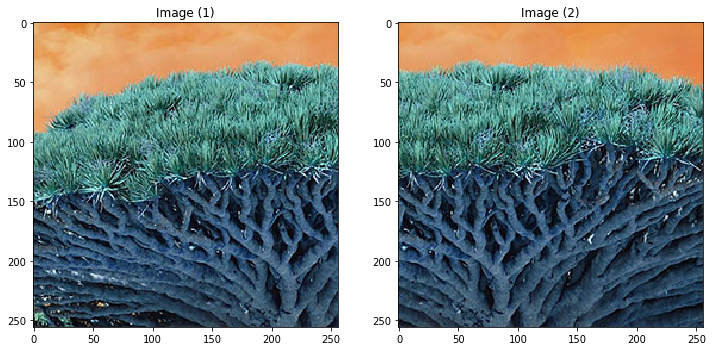

[[ 1.03185880e+00  2.73661383e-02 -4.25682478e+00]
 [-1.72015924e-02  1.06150833e+00 -3.08282691e-01]
 [-3.45916575e-04  4.25787678e-04  1.00000000e+00]]


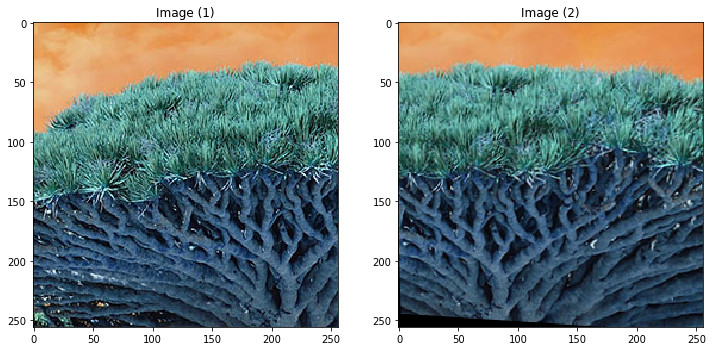

In [21]:
count = 0
img = cv2.imread("tree.jpg")
img_h = img.shape[0]
img_w = img.shape[1]
begin_y = 50
begin_x = 50
snip_height = 256
snip_width = 256
x1, y1 = 16, 78
x2, y2 = 111, 78
x3, y3 = 111, 178
x4, y4 = 16, 178

l_x1, l_y1 = 16 + 128, 78
l_x2, l_y2 = 111 + 128, 78
l_x3, l_y3 = 111 + 128, 178
l_x4, l_y4 = 16 + 128, 178 

curr_x = begin_x
curr_y = begin_y

w_overlap_ratio = 0.5

while (curr_y < img_h - snip_height):
    while (curr_x < img_w - (snip_width + snip_width * (1 - w_overlap_ratio))):

        l_l = curr_x
        l_t = curr_y

        r_l = int(l_l + snip_width * (1 - w_overlap_ratio))
        r_t = l_t
        img_l = img[l_t:l_t+snip_height, l_l:l_l+snip_width, :]
        img_r = img[r_t:r_t+snip_height, r_l:r_l+snip_width, :]

        curr_x += snip_width

        show_images([img_l, img_r], 1)
        crop = img_l[y1:y3, x1:x2, :]
        rho = 4
        perturb1_x, perturb1_y = random.randint(-rho, rho), random.randint(-rho, rho)
        perturb2_x, perturb2_y = random.randint(-rho, rho), random.randint(-rho, rho)
        perturb3_x, perturb3_y = random.randint(-rho, rho), random.randint(-rho, rho)
        perturb4_x, perturb4_y = random.randint(-rho, rho), random.randint(-rho, rho)

        new_x1, new_y1 = x1 + perturb1_x, y1 + perturb1_y
        new_x2, new_y2 = x2 + perturb2_x, y2 + perturb2_y
        new_x3, new_y3 = x3 + perturb3_x, y3 + perturb3_y
        new_x4, new_y4 = x4 + perturb4_x, y4 + perturb4_y

#         print("{}, {}, {}, {}".format(perturb1_x, perturb1_y, perturb3_x, perturb3_y))
#         print("{}, {}, {}, {}, {}, {}, {}, {}".format(new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4))
#         plt.imshow(img_l[y1:y3, x1:x2, :])

        pts1 = np.float32([[x1, y1],[x2, y2],[x3, y3], [x4, y4]])
        pts2 = np.float32([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]])
        l_pts1 = np.float32([[l_x1, l_y1], [l_x2, l_y2], [l_x3, l_y3], [l_x4, l_y4]])

        M_within = cv2.getPerspectiveTransform(pts1, pts2)
#         print(M_within)
        dst = cv2.warpPerspective(img_r, M_within, (256, 256))

        M_between = cv2.getPerspectiveTransform(pts2, l_pts1)

        result = cv2.warpPerspective(dst, M_between, 
            (img_r.shape[1]+img_l.shape[1], img_r.shape[0]))
        result[0:img_l.shape[0], 0:img_l.shape[1]] = img_l

#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(l_x1, l_y1, l_x2, l_y2, l_x3, l_y3, l_x4, l_y4))
#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4))
#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(new_x1 - l_x1, new_y1 - l_y1, new_x2 - l_x2, new_y2 - l_y2, 
#                                                               new_x3 - l_x3, new_y3 - l_y3, new_x4 - l_x4, new_y4 - l_y4))

#                 d1_x = new_x1 - x1
#                 d1_y = new_y1 - y1
#                 d2_x = new_x2 - x2
#                 d2_y = new_y2 - y2
#                 d3_x = new_x3 - x3
#                 d3_y = new_y3 - y3
#                 d4_x = new_x4 - x4
#                 d4_y = new_y4 - y4

#                 corners1 = np.float32([[0, 0],[255, 0],[255, 255], [0, 255]])
#                 corners2 = np.float32([[0 + d1_x, 0 + d1_y],[255 + d2_x, 0 + d2_y],[255 + d3_x, 255 + d3_y], [0 + d4_x, 255 + d4_y]])
#                 print(corners2)
#                 M_corners = cv2.getPerspectiveTransform(corners1, corners2)
#                 print(M_corners)
#                 print(M_within)
#                 print(M_between)
        corner1 = np.dot(M_between,  np.array([[0], [0], [1]]))
        corner2 = np.dot(M_between,  np.array([[255], [0], [1]]))
        corner3 = np.dot(M_between,  np.array([[255], [255], [1]]))
        corner4 = np.dot(M_between,  np.array([[0], [255], [1]]))
        corner1 /= corner1[2,0]
        corner2 /= corner2[2,0]
        corner3 /= corner3[2,0]
        corner4 /= corner4[2,0]

        d1_x = corner1[0,0] - 0
        d1_y = corner1[1,0] - 0
        d2_x = corner2[0,0] - 255
        d2_y = corner2[1,0] - 0
        d3_x = corner3[0,0] - 255
        d3_y = corner3[1,0] - 255
        d4_x = corner4[0,0] - 0
        d4_y = corner4[1,0] - 255


        np.savez_compressed('corner_difference/{}'.format(count), np.array([d1_x, d1_y, d2_x, d2_y, d3_x, d3_y, d4_x, d4_y]))
        np.savez_compressed('left_images_perturb_50/{}'.format(count), img_l)
        np.savez_compressed('right_images_perturb_50/{}'.format(count), dst)
        np.savez_compressed('homography_perturbed_50/{}'.format(count), M_between)
        show_images([img_l, dst], 1)
        
        count += 1

#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(d1_x, d1_y, d2_x, d2_y, d3_x, d3_y, d4_x, d4_y))

#                 corners1 = np.float32([[0, 0], [255, 0], [255, 255], [0, 255]])
#                 corners2 = np.float32([[0 + d1_x, 0 + d1_y], [255 + d2_x, 0 + d2_y],
#                                                                      [255 + d3_x, 255 + d3_y], [0 + d4_x, 255 + d4_y]])
#                 M_corners = cv2.getPerspectiveTransform(corners1, corners2)
# #                 print(M_corners)
# #                 print(M_between)
#                 check_res = cv2.warpPerspective(dst, M_corners, 
#                     (img_r.shape[1]+img_l.shape[1], img_r.shape[0]))
#                 check_res[0:img_l.shape[0], 0:img_l.shape[1]] = img_l



#                 img_r_warped = cv2.warpPerspective(img_r, M_corners, (256, 256))

#                 show_images([img_l, dst, result], 1)
#                 break

    curr_y += snip_height
#             break
#         break

In [6]:
loaded = np.load('left_images_perturb_50/{}.npz'.format(1))
print(loaded)

In [7]:
index = 1

import PIL
from PIL import Image
import torchvision

tr = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()])

img_left = np.load("left_images_perturb_50/{}.npz".format(index))['arr_0']
img_left = Image.fromarray(img_left)
tr_img_left = tr(img_left)

img_right = np.load("right_images_perturb_50/{}.npz".format(index))['arr_0']
img_right = Image.fromarray(img_right)
tr_img_right = tr(img_right)

stacked = torch.cat((tr_img_left, tr_img_right), dim = 0)

In [8]:
stacked


tensor([[[0.7412, 0.7412, 0.7333,  ..., 0.6353, 0.6275, 0.6275],
         [0.7333, 0.7294, 0.7255,  ..., 0.6353, 0.6275, 0.6275],
         [0.7333, 0.7333, 0.7216,  ..., 0.6353, 0.6275, 0.6275],
         ...,
         [0.0706, 0.0667, 0.0235,  ..., 0.0902, 0.1255, 0.1373],
         [0.0824, 0.0549, 0.1255,  ..., 0.0863, 0.1176, 0.1294],
         [0.1490, 0.1255, 0.1765,  ..., 0.1059, 0.1216, 0.1373]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2275, 0.2353, 0.2353,  ..., 0.2275, 0.2039, 0.1961],
         [0.2784, 0.2471, 0.2275,  ..., 0.2510, 0.2353, 0.2039],
         [0.2902, 0.2667, 0.2549,  ..., 0.2824, 0.2667, 0.2314]]])

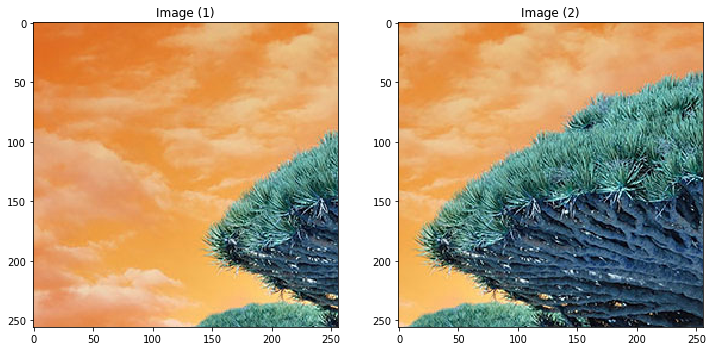

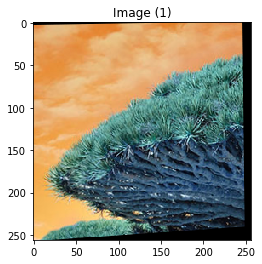

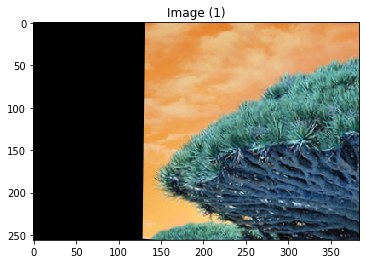

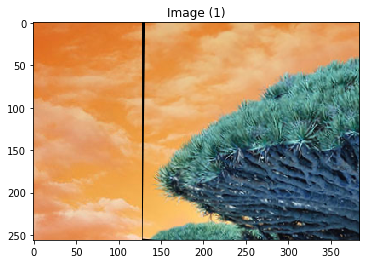

[[131.11241579]
 [ -3.03351672]
 [  1.        ]]
[[393.71968359]
 [  0.91407113]
 [  1.        ]]
[[390.77190373]
 [272.23137602]
 [  1.        ]]
[[128.61305308]
 [253.64749793]
 [  1.        ]]
[131.1124157858115, -3.0335167191345365, 138.71968359100555, 0.9140711288956099, 135.77190373278984, 272.23137601704354, 128.61305307692584, 253.6474979322486]


In [30]:
img = cv2.imread("tree.jpg")
img_h = img.shape[0]
img_w = img.shape[1]
begin_y = 50
begin_x = 50
snip_height = 256
snip_width = 256
x1, y1 = 16, 78
x2, y2 = 111, 78
x3, y3 = 111, 178
x4, y4 = 16, 178

l_x1, l_y1 = 16 + 128, 78
l_x2, l_y2 = 111 + 128, 78
l_x3, l_y3 = 111 + 128, 178
l_x4, l_y4 = 16 + 128, 178 

curr_x = begin_x
curr_y = begin_y

w_overlap_ratio = 0.5

l_l = curr_x
l_t = curr_y

r_l = int(l_l + snip_width * (1 - w_overlap_ratio))
r_t = l_t
img_l = img[l_t:l_t+snip_height, l_l:l_l+snip_width, :]
img_r = img[r_t:r_t+snip_height, r_l:r_l+snip_width, :]

curr_x += snip_width

show_images([img_l, img_r], 1)
crop = img_l[y1:y3, x1:x2, :]
rho = 4
perturb1_x, perturb1_y = random.randint(-rho, rho), random.randint(-rho, rho)
perturb2_x, perturb2_y = random.randint(-rho, rho), random.randint(-rho, rho)
perturb3_x, perturb3_y = random.randint(-rho, rho), random.randint(-rho, rho)
perturb4_x, perturb4_y = random.randint(-rho, rho), random.randint(-rho, rho)

new_x1, new_y1 = x1 + perturb1_x, y1 + perturb1_y
new_x2, new_y2 = x2 + perturb2_x, y2 + perturb2_y
new_x3, new_y3 = x3 + perturb3_x, y3 + perturb3_y
new_x4, new_y4 = x4 + perturb4_x, y4 + perturb4_y

#                 print("{}, {}, {}, {}".format(perturb1_x, perturb1_y, perturb3_x, perturb3_y))
#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4))
#                 plt.imshow(img_l[y1:y3, x1:x2, :])

pts1 = np.float32([[x1, y1],[x2, y2],[x3, y3], [x4, y4]])
pts2 = np.float32([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]])
l_pts1 = np.float32([[l_x1, l_y1], [l_x2, l_y2], [l_x3, l_y3], [l_x4, l_y4]])

M_within = cv2.getPerspectiveTransform(pts1, pts2)

dst = cv2.warpPerspective(img_r, M_within, (256, 256))
show_images([dst])
M_between = cv2.getPerspectiveTransform(pts2, l_pts1)


result = cv2.warpPerspective(dst, M_between, 
    (img_r.shape[1]+img_l.shape[1] - 128, img_r.shape[0]))
show_images([result])
result[0:256, 0:128] = img_l[:, 0:128]
show_images([result])

#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(l_x1, l_y1, l_x2, l_y2, l_x3, l_y3, l_x4, l_y4))
#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4))
#                 print("{}, {}, {}, {}, {}, {}, {}, {}".format(new_x1 - l_x1, new_y1 - l_y1, new_x2 - l_x2, new_y2 - l_y2, 
#                                                               new_x3 - l_x3, new_y3 - l_y3, new_x4 - l_x4, new_y4 - l_y4))

#                 d1_x = new_x1 - x1
#                 d1_y = new_y1 - y1
#                 d2_x = new_x2 - x2
#                 d2_y = new_y2 - y2
#                 d3_x = new_x3 - x3
#                 d3_y = new_y3 - y3
#                 d4_x = new_x4 - x4
#                 d4_y = new_y4 - y4

#                 corners1 = np.float32([[0, 0],[255, 0],[255, 255], [0, 255]])
#                 corners2 = np.float32([[0 + d1_x, 0 + d1_y],[255 + d2_x, 0 + d2_y],[255 + d3_x, 255 + d3_y], [0 + d4_x, 255 + d4_y]])
#                 print(corners2)
#                 M_corners = cv2.getPerspectiveTransform(corners1, corners2)
#                 print(M_corners)
#                 print(M_within)
#                 print(M_between)
corner1 = np.dot(M_between,  np.array([[0], [0], [1]]))
corner2 = np.dot(M_between,  np.array([[255], [0], [1]]))
corner3 = np.dot(M_between,  np.array([[255], [255], [1]]))
corner4 = np.dot(M_between,  np.array([[0], [255], [1]]))


corner1 /= corner1[2,0]
corner2 /= corner2[2,0]
corner3 /= corner3[2,0]
corner4 /= corner4[2,0]

print(corner1, corner2, corner3, corner4, sep='\n')


d1_x = corner1[0,0] - 0
d1_y = corner1[1,0] - 0
d2_x = corner2[0,0] - 255
d2_y = corner2[1,0] - 0
d3_x = corner3[0,0] - 255
d3_y = corner3[1,0] - 0
d4_x = corner4[0,0] - 0
d4_y = corner4[1,0] - 0

print([d1_x, d1_y, d2_x, d2_y, d3_x, d3_y, d4_x, d4_y])
